# グリコゲームの数値解を求める

Qiita記事 → https://qiita.com/yasagureprog/items/26d34a791180b447e0db

# 求解クラスを作成

## パラメータの設定

必要ライブラリのインポート、matplotlibの設定を行う

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
config = {
    'font.family':'Yu Mincho',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'font.size': 14,
    'axes.linewidth': 1.0,
    'figure.dpi': 144
}
plt.rcParams.update(config)

## 求解条件を作成

- length ... 階段の高さ
- rewards ... 自分&相手の出した手に対応した、進める段数の定義行列

In [114]:
length = 2
rewards = np.array([
            [0, 1, 0], # グー
            [0, 0, 2], # チョキ
            [2, 0, 0]  # パー
        ])

np.vstack([rewards, rewards])

array([[0, 1, 0],
       [0, 0, 2],
       [2, 0, 0],
       [0, 1, 0],
       [0, 0, 2],
       [2, 0, 0]])

## ソルバークラスを作成

In [115]:
class Solver:
    def __init__(self, length, rewards):
        self.length = length
        self.rewards = rewards
        self.hand_size = rewards.shape[0]

    def make_init(self):
        V = np.zeros(self.length*self.length)
        H = np.full(self.length*self.length*(self.hand_size-1), 1/3)
        return np.append(V, H, axis=0)

    def make_equations(self, x):
        unit = self.length**2
        V = np.zeros((self.length+1, self.length+1))
        V[1:, 1:] = x[:unit].reshape((self.length, self.length))
        V[:, 0] -= 1
        V[0, :] += 1

        H = x[unit:].reshape((self.hand_size-1, self.length, self.length))
        H = np.vstack([H, [1-H.sum(axis=0)]])
        R = np.zeros((self.hand_size, self.length, self.length))
        for i in range(1, self.length+1):
            for j in range(1, self.length+1):
                x = V[np.where(i-self.rewards <= 0, 0, i-self.rewards), np.where(j-self.rewards.T <= 0, 0, j-self.rewards.T)] @ H[:,j-1,i-1].T - V[i,j]
                #print(x)
                R[:,i-1,j-1] = x
        R = R.reshape(self.hand_size*self.length**2)
        return R

    def solve(self):
        self.result = optimize.root(self.make_equations, self.make_init(), method="hybr")
        x = self.result["x"]
        unit = self.length**2
        self.V = x[:unit].reshape((self.length, self.length))
        self.H = x[unit:].reshape((self.hand_size-1, self.length, self.length))
        self.H = np.vstack([self.H, [1-self.H.sum(axis=0)]])

        if self.result["success"] == False: raise Exception("cannot find variable solution")


## 求解
- stair_length = 階段の段数
- hands_num = 出せる手の数(グーチョキパーなら3)
- rewards = 大きさ(hands_num, hands_num)のリスト。双方が出した手ごとに、(自分が進む歩数, 相手が進む歩数)を指定する。

In [116]:
solver = Solver(length, rewards)

solver.solve()
v_list, qg_list, qc_list = solver.V, solver.H[0], solver.H[1]

In [119]:
solver.V

array([[ 3.40729006e-21,  2.58055872e-01],
       [-2.58055872e-01, -5.00810459e-19]])

## プロット
- qg_list, qc_list指定で色付け
- 指定なしで期待利得のみ描画

In [118]:
def myplot3d(v_list, qg_list = [], qc_list = []):
    x, y = np.meshgrid(np.arange(stair_length), np.arange(stair_length))
    x, y = x.ravel(), y.ravel()
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection='3d')
    if len(qg_list) == len(qc_list) == len(v_list):
        col_list = [(i, j, k) for i, j, k in zip(qg_list.T.ravel(), qc_list.T.ravel(), 1-qg_list.T.ravel()-qc_list.T.ravel())]
        
        ax.bar3d(x+0.5, y+0.5, np.zeros_like(x)-1, 1, 1, v_list.T.ravel()+1, color=col_list)
        ax.scatter([], [], color="r", label="グー")
        ax.scatter([], [], color="g", label="チョキ")
        ax.scatter([], [], color="b", label="パー")
        ax.legend()
    else:
        ax.bar3d(x+0.5, y+0.5, np.zeros_like(x)-1, 1, 1, v_list.T.ravel()+1)
    ax.set_zlim(-1, 1)
    ax.set_xlim(0.1, stair_length+1)
    ax.set_ylim(0.1, stair_length+1)
    ax.set_xlabel("自分の残り歩数")
    ax.set_ylabel("相手の残り歩数")
    ax.set_zlabel("期待利得")

#qg_list1, qc_list1 = qg_list, qc_list
myplot3d(v_list, qg_list, qc_list)

NameError: name 'stair_length' is not defined

## 大規模問題を効率的に解く
- fast_optimizer()
- optimizerに比べて高速
- 問題によっては誤差が無視できなかったり、階段を戻る行程がある場合は正しい解が得られない
- 極端な場合に弱い

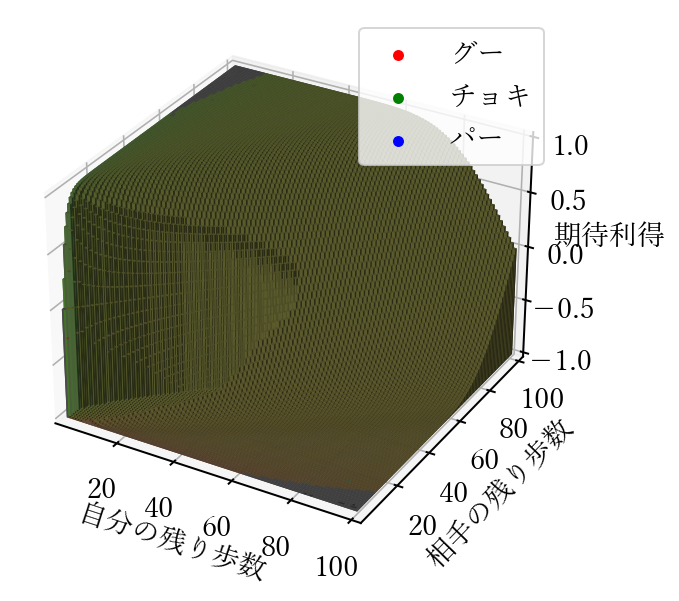

In [ ]:
stair_length = 100

def fast_optimizer(stair_length, hands_num, rewards):
    v_list = np.zeros((stair_length, stair_length))
    qg_list = np.full((stair_length, stair_length), 0.33)
    qc_list = np.full((stair_length, stair_length), 0.33)
    
    for a in range(stair_length*2-1):
        for b in range(max(0, a-stair_length+1), min(a+1, stair_length)):
            i, j = b, a-b
            func = lambda x: make_eqs(make_rewards(v_list, i, j, v0=x[0]), x[1:], x[0])
            v, qg, qc = optimize.root(func, [v_list[i][j], qg_list[j][i], qc_list[j][i]])["x"]
            v_list[i][j], qg_list[j][i], qc_list[j][i] = v, qg, qc
    return (v_list, qg_list, qc_list)

v_list, qg_list, qc_list = fast_optimizer(stair_length, hands_num, rewards)
myplot3d(v_list, qg_list, qc_list)

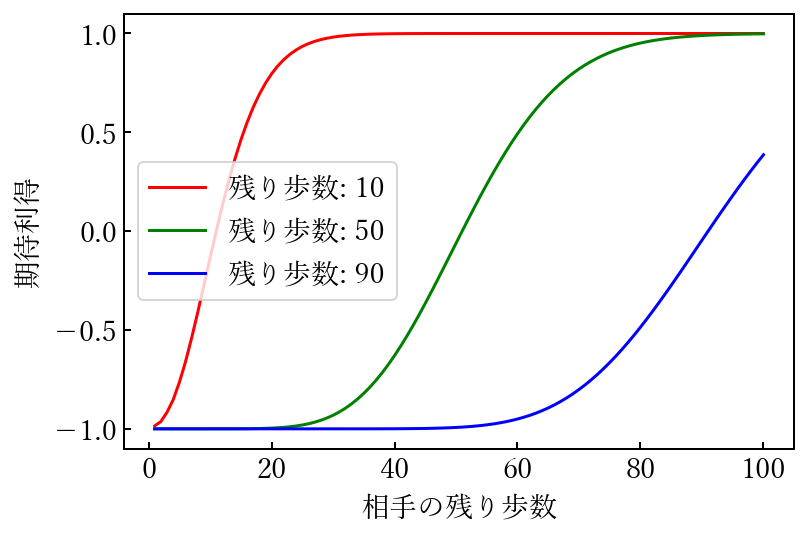

In [ ]:
plt.plot(np.arange(1, stair_length+1), v_list[10,:], "r-", label="残り歩数: 10")
plt.plot(np.arange(1, stair_length+1), v_list[50,:], "g-", label="残り歩数: 50")
plt.plot(np.arange(1, stair_length+1), v_list[90,:], "b-", label="残り歩数: 90")
plt.xlabel("相手の残り歩数")
plt.ylabel("期待利得")
plt.legend()

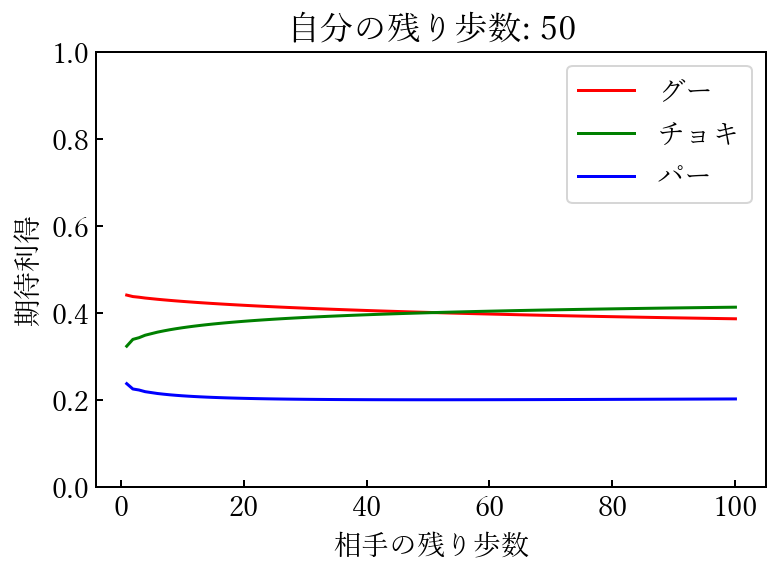

In [ ]:
plt.plot(np.arange(1, 101), qg_list[50,:], "r-", label="グー")
plt.plot(np.arange(1, 101), qc_list[50,:], "g-", label="チョキ")
plt.plot(np.arange(1, 101), 1-qg_list[50,:]-qc_list[50,:], "b-", label="パー")
plt.ylim(0, 1)
plt.xlabel("相手の残り歩数")
plt.ylabel("期待利得")
plt.title("自分の残り歩数: 50")
plt.legend()

## 様々な条件で求解

### ①グーで勝てば10歩、チョキは2歩、パーは1歩だけ

True
The relative error between two consecutive iterates is at most 0.000000


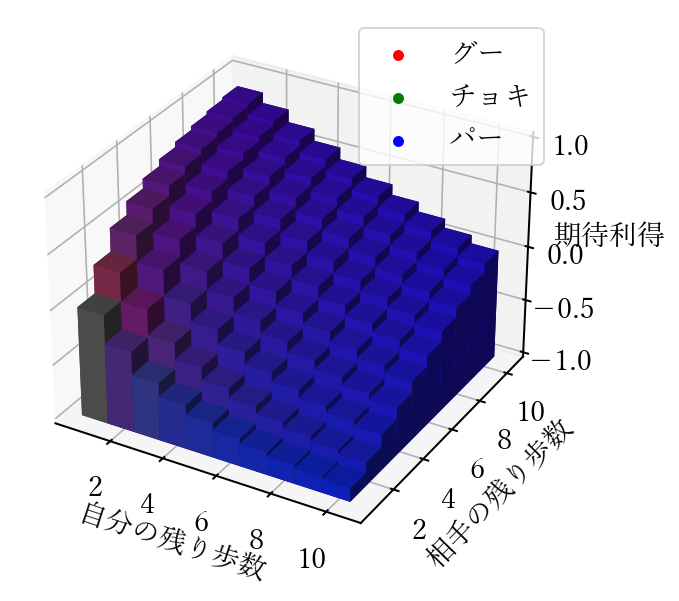

In [ ]:
stair_length = 10
hands_num = 3
rewards = [[(0, 0), (10, 0), (0, 1)],
         [(0, 10), (0, 0), (2, 0)],
         [(1, 0), (0, 2), (0, 0)]]

v_list, qg_list, qc_list = optimizer(stair_length, hands_num, rewards)
myplot3d(v_list, qg_list, qc_list)

### ②グリコゲームだが負けたらふりだしに戻る

True
The relative error between two consecutive iterates is at most 0.000000


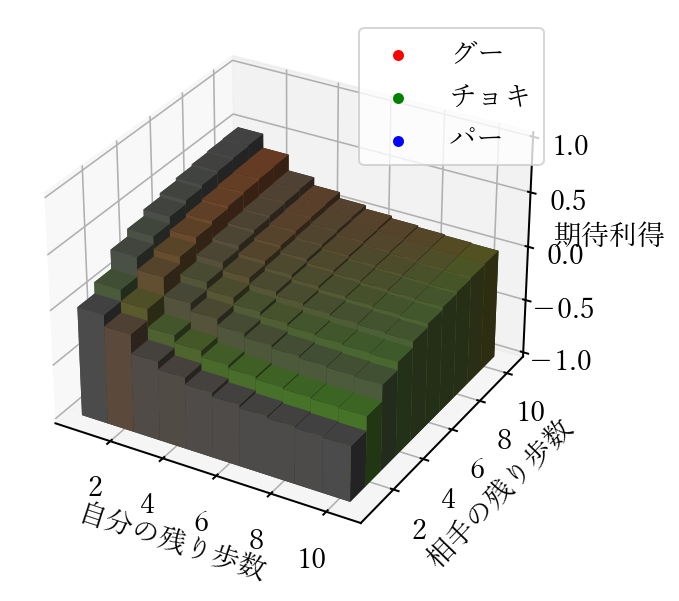

In [ ]:
stair_length = 10
hands_num = 3
rewards = [[(0, 0), (1, -100), (-100, 2)],
         [(-100, 1), (0, 0), (2, -100)],
         [(2, -100), (-100, 2), (0, 0)]]

v_list, qg_list, qc_list = optimizer(stair_length, hands_num, rewards)
myplot3d(v_list, qg_list, qc_list)

# テンプレート

True
The relative error between two consecutive iterates is at most 0.000000


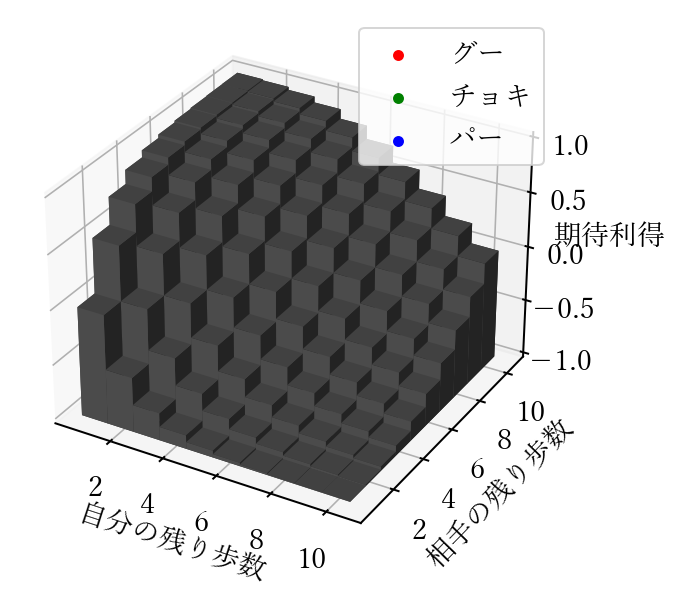

In [ ]:
stair_length = 10
hands_num = 3
rewards = [[(0, 0), (1, 0), (0, 1)],
         [(0, 1), (0, 0), (1, 0)],
         [(1, 0), (0, 1), (0, 0)]]

v_list, qg_list, qc_list = optimizer(stair_length, hands_num, rewards)
myplot3d(v_list, qg_list, qc_list)